## Import 

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 둘러보기

In [23]:
feature_name_df=pd.read_csv('./human_activity/human_activity/features.txt', sep='\s+', 
                           header=None, names=['column_idx', 'column_name'])
print(feature_name_df.shape)
feature_name_df.head(10)

(561, 2)


,column_idx,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
5,6,tBodyAcc-std()-Z
6,7,tBodyAcc-mad()-X
7,8,tBodyAcc-mad()-Y
8,9,tBodyAcc-mad()-Z
9,10,tBodyAcc-max()-X


In [21]:
feature_name_df['column_name'].unique().shape

(477,)

#### 칼럼개수가 477개인걸 보아 중복된 칼럼제거가 안되어있음을 알 수 있다

In [17]:
feature_dup_df=feature_name_df.groupby('column_name').count()
feature_dup_df

,column_idx
column_name,
"angle(X,gravityMean)",1
"angle(Y,gravityMean)",1
"angle(Z,gravityMean)",1
"angle(tBodyAccJerkMean),gravityMean)",1
"angle(tBodyAccMean,gravity)",1
...,...
tGravityAccMag-max(),1
tGravityAccMag-mean(),1
tGravityAccMag-min(),1


In [20]:
# 중복 칼럼 체크
tmp_df=feature_dup_df[feature_dup_df['column_idx']>1]
print(tmp_df.count())
tmp_df.head(10)

column_idx    42
dtype: int64


,column_idx
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3
"fBodyAcc-bandsEnergy()-25,32",3
"fBodyAcc-bandsEnergy()-25,48",3
"fBodyAcc-bandsEnergy()-33,40",3
"fBodyAcc-bandsEnergy()-33,48",3


In [24]:
def new_df(old_df):
    feature_dup_df = pd.DataFrame(data=old_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_df = pd.merge(old_df.reset_index(), feature_dup_df, how='outer')
    new_df['column_name'] = new_df[['column_name', 'dup_cnt']].apply(
        lambda x: x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_df = new_df.drop(['index'], axis=1)
    return new_df 

## 데이터셋 가져오기

In [26]:
path='./human_activity/human_activity/'
feature_name_df=pd.read_csv(path+'features.txt', sep='\s+', 
                           header=None, names=['column_idx', 'column_name'])
feature_name_df=new_df(feature_name_df)
feature_name=feature_name_df.iloc[:,1].values.tolist()
X_train = pd.read_csv(path+'train/X_train.txt', sep='\s+', names=feature_name)
X_test = pd.read_csv(path+'test/X_test.txt', sep='\s+', names=feature_name)   
y_train = pd.read_csv(path+'train/y_train.txt', sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(path+'test/y_test.txt', sep='\s+', header=None, names=['action'])

In [29]:
X_train.shape, X_test.shape

((7352, 561), (2947, 561))

In [50]:
y_train['action'].unique()

array([5, 4, 6, 1, 3, 2], dtype=int64)

In [34]:
print(y_train['action'].value_counts()/y_train.shape[0]) # target의 분포상태 좋음

6    0.191376
5    0.186888
4    0.174918
1    0.166757
2    0.145947
3    0.134113
Name: action, dtype: float64


## DecisionTree로 훈련하고 평가하기

In [35]:
from sklearn.tree import DecisionTreeClassifier
dt_clf=DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
print("기본 결정트리 예측도: ", dt_clf.score(X_test, y_test))

기본 결정트리 예측도:  0.8622327790973872


## GridSearch

In [36]:
from sklearn.model_selection import GridSearchCV
params={'max_depth':[6,8,10,12,16,20,24], 
        'min_samples_split':[16]}
grid=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
print("최고 정확도: ", grid.best_score_)
print("최적 파라미터: ", grid.best_params_)

최고 정확도:  0.8506627450436326
최적 파라미터:  {'max_depth': 10, 'min_samples_split': 16}


In [38]:
cv_ret_df=pd.DataFrame(grid.cv_results_)
cv_ret_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.844398
1,8,0.849710
2,10,0.850663
3,12,0.841551
4,16,0.847944
5,20,0.847672
6,24,0.847672


## 테스트 데이터로 평가해보기

In [39]:
depths=[6,8,10,12,16,20,24]
for d in depths:
    dt_clf=DecisionTreeClassifier(max_depth=d, min_samples_split=16, random_state=42)
    dt_clf.fit(X_train, y_train)
    score = dt_clf.score(X_test, y_test)
    print(f'max_depth:{d}, 정확도:{np.round(score,4)} ')

max_depth:6, 정확도:0.8548 
max_depth:8, 정확도:0.8711 
max_depth:10, 정확도:0.8677 
max_depth:12, 정확도:0.8616 
max_depth:16, 정확도:0.8619 
max_depth:20, 정확도:0.8626 
max_depth:24, 정확도:0.8626 


## 2개 파라미터 튜닝하기

In [51]:
params={'max_depth':[8, 10, 12], 
        'min_samples_split':[8, 10, 12]}
grid=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
print("최고 정확도: ", grid.best_score_)
print("최적 파라미터: ", grid.best_params_)

최고 정확도:  0.8555589468962296
최적 파라미터:  {'max_depth': 8, 'min_samples_split': 12}


In [52]:
cv_ret_df=pd.DataFrame(grid.cv_results_)
cv_ret_df[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]

,param_max_depth,param_min_samples_split,mean_test_score
0,8,8,0.851615
1,8,10,0.853654
2,8,12,0.855559
3,10,8,0.848488
4,10,10,0.848351
5,10,12,0.848351
6,12,8,0.841415
7,12,10,0.842776
8,12,12,0.845224


In [53]:
dt_clf_best=grid.best_estimator_
print("최적 성능: ", dt_clf_best.score(X_test, y_test))


최적 성능:  0.8717339667458432


## 칼럼별 중요도 확인

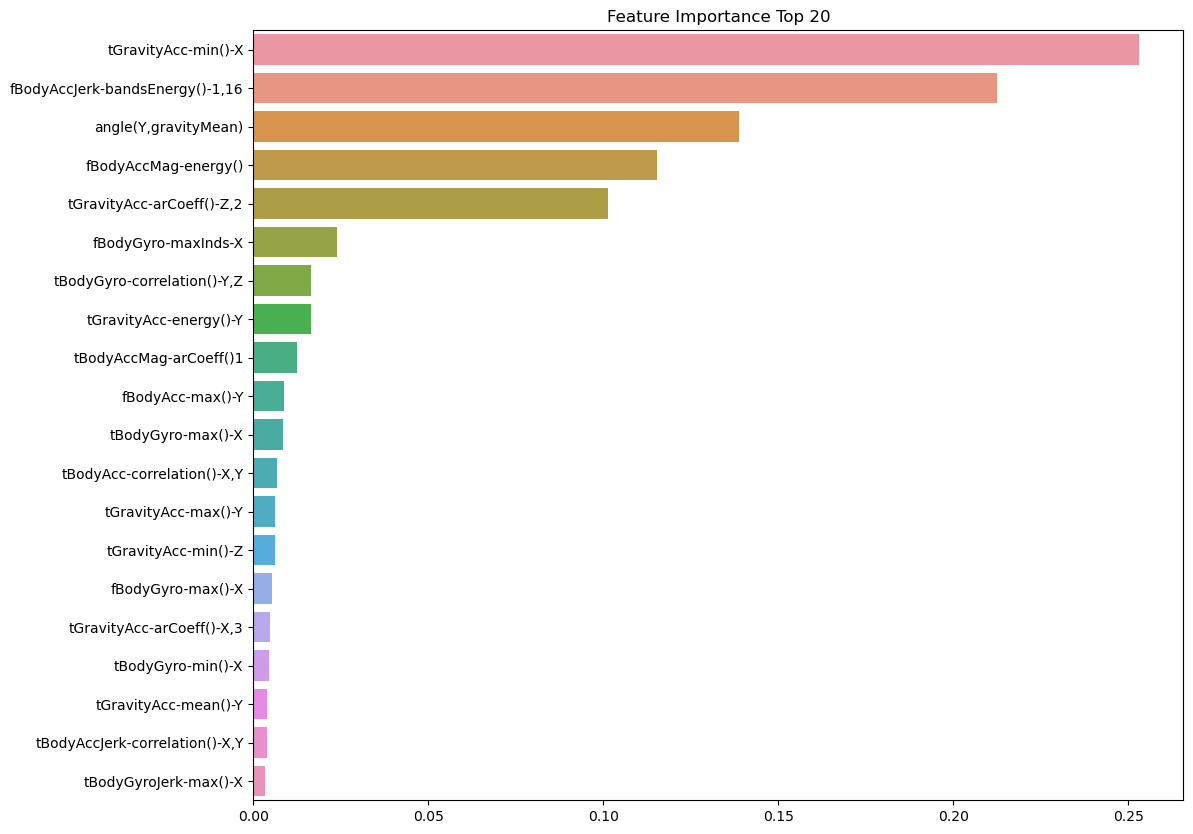

In [54]:
importance=dt_clf_best.feature_importances_
importance=pd.Series(importance, index=X_train.columns)
top20=importance.sort_values(ascending=False)[:20]
plt.figure(figsize=(12, 10))
plt.title('Feature Importance Top 20')
sns.barplot(x=top20, y=top20.index)
plt.show();